## Using Neural Network for studies of Brownian motion in a complex potential landscape

### Potential energy landscape and force
Neural network is known to be able to express any function, $V(\mathbf{x})$, where $\mathbf{x}$ is a vector in a high-dimensional space. 

For instance, in a geographic (three-dimensional) coordinate system the components of the vector $\mathbf{x}$ are latitude and longitude and the function $V(\mathbf{x})$ could be potential energy at location $\mathbf{x}$ relative to potential energy at sea surface.

In this notebook, I consider a two-dimensional system where the in put to the function $V(x)$ is the position of a particle in the $x$ direction and $V(x)$ is the corresponding potential energy.

In addition, I discuss the motion of a Brownian particle in a potential energy surface, where the magnitude of force is
\begin{align}
&F(x) = \frac{V(x + \delta / 2) - V(x - \delta / 2)}{\delta } 
&\mbox{Equation (1)}
\end{align}
determined by the potential energy difference between two points separated by a small distance $\delta$.

###  Brownian motion in a potential energy surface
Brownian motion is the random motion of particles named after a botanist Robert Brown. This mechenism that causes this motion is later explained by Albert Einstein in his paper "On the movement of small particles suspended in a stationary liquid demanded by the molecular-kinetic theory of heat" in 1905.

The dynamics of a Browian particle in one dimension is a Wiener process and the corresponding dynamical equation is
\begin{align}
&x(t+dt) = x(t) + \frac{1}{\gamma} F(x) dt  + \sqrt{2D dt} \zeta(t),
&\mbox{Equation (2)}
\end{align}
where $F(x)$ is the force acting on the particle due to the gradient of $V(x)$, the $ \sqrt{2D dt} \zeta(t)$ is the random movement due to thermal noise that is assumed uncorrelated between subsequent time steps. The constant $\gamma$ and $D$ are the friction coefficient and the diffusion constant, respectively, which are linked by the Einstein relation
\begin{equation}
D = \frac{k_BT}{\gamma},
\end{equation}
with $k_BT$ the thermal energy with $k_B$ the Boltzmann constant and $T$ is the temperature.

###  Using neural network to represent a potential energy surface
In high dimensions, the potential energy surface is usually complex and not easy to express analytically. Here a neural network will be use to reconstruct the potential energy surface. In this notebook I will consider a simple potentail surface that consists of two local minima. The potential is a sum of two Gaussian-like wells
\begin{align}
&V(x) = - E_a e^{-(x-x_a)^2 / \sigma_a} - E_b e^{-(x-x_b)^2/ \sigma_b},
&\mbox{Equation (3)}
\end{align}
where $E_{a,b}$ control the depth of the wells and $x_{a,b}$, $\sigma_{a,b}$ determine the center and the width of the wells, respectively.

I will use a fully-connected neural network with two hidden-layers each with $50$ neurons to reconstruct the potential energy surface. The network is trained with a set of positions $x$ as the input and their corresponding potential energy $V(x)$ as the output. After training, the network can be used to predict the potential energy (output) given the poistion of the particle (input to the network).

###  Simulating Brownian particle dynamics in a potential energy surface
To simulate the motion of a Brownian particle in this potential energy surface, the particle is placed at an initial position $x_0$ and  the force is computed based on Equation (1). Then the time evoluation of its position is solved iteratively using Equation (2). The friction coefficient is chosen to be $\gamma = 50$ and the value of the diffusion constant is $D = k_BT/\gamma$ based on the Einstein relation. To test the method, the equilibrium population of an ensemble of Brownian particles obtained from simulations will be compared to the thermal dynamic prediction.



### Get started, first load the packages 

In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import sklearn.model_selection as skms
import keras.utils as ku
import keras.models as km
import keras.layers as kl
import keras.regularizers as kr
import keras.initializers as ki

Using TensorFlow backend.


### Define the target function that output $V(x)$ and generate data randomly along $x$
The paramenters for $V(x)$ are chosen as $E_a = -10$, $x_a = -1.5$, $\sigma_a = 2$ and $E_b = -12$, $x_b = 1.5$, $\sigma_b = 5$. 

In [2]:
def V(x):
    '''
    define the target potential function
    '''
    Ea = -10.0; x_a = -1.5; sigma_a = 2.0
    Eb = -12.0; x_b = 1.5 ; sigma_b = 2.0
    return Ea*np.exp(-(x-x_a)**2 / sigma_a) + Eb*np.exp(-(x-x_b)**2/sigma_b)

def generate_random_data(n):
    '''
    generate random points along the x-axis ranging from x=-5 to x=5 
    and compute V(x) using target function at each x
    '''
    # generate random points along the x-axis ranging from x=-5 to x=5
    np.random.seed(21)
    x = ( np.random.random(n) - 0.5 ) * 2.0 * 5.0
    
    # compute V(x) using target function at each x
    V_x = V(x)
    
    return x, V_x

, and plot the potential function

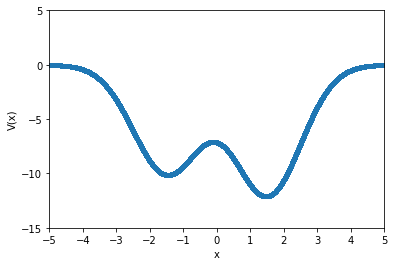

In [3]:
# generate n random data
n = 100000
x, V_x = generate_random_data(n)

plt.plot(x, V_x, ".")
plt.xlim(-5,5)
plt.ylim(-15,2.5)
plt.xticks(np.arange(-5.0, 5.01, 1.0))
plt.yticks(np.arange(-15.0, 5.01, 5.0))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.show()

### Train the neural network to reconstruct the potential function

First, we perform feature scaling and mean normalization on the height of the potential function to make training converge faster,

In [4]:
# Perform feature scaling and mean normalization on the height of the potential function

V_x_std = np.std(V_x)    # compute the standard deviation of y
V_x_mean = np.mean(V_x)  # compute the mean of y
V_x_rescaled = ( V_x - V_x_mean ) / V_x_std # perform feature scaling and mean normalization

and split data into training and test sets.

In [5]:
# split data into training and test sets
X_train, X_test, V_x_train, V_x_test = skms.train_test_split(x, V_x_rescaled, test_size=0.2, random_state=21)

### Construct the network
The network has a sinlge input node and a single output node with two hidden layers each with 50 nodes

In [6]:
def NN_model(num_hidden_nodes, input_size = 1, output_size = 1):
    # Initialize the model.
    model = km.Sequential()

    # Add two hidden fully-connected layers
    model.add(kl.Dense(num_hidden_nodes, 
                       input_dim = input_size, 
                       activation = 'relu', 
                      ))
    
    model.add(kl.Dense(num_hidden_nodes, 
                       activation = 'relu', 
                      ))

    # Add the output layer.
    model.add(kl.Dense(output_size, activation ='linear'))

    # Return the model.
    return model

In [7]:
# Train the network
num_hidden_nodes = 50
model = NN_model(num_hidden_nodes)
model.summary()
model.compile(optimizer='adam', loss="mean_squared_error")
fit = model.fit(X_train, V_x_train, epochs=50, batch_size=100, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


## Evaluate the test set

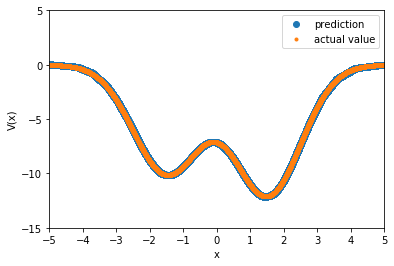

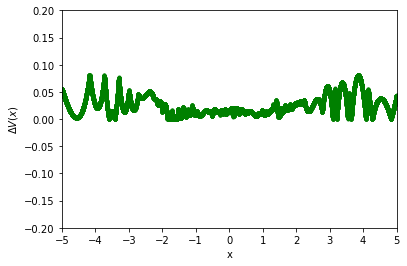

In [8]:
# Plot the prediction of test set and difference between the actual value and the predicted value

def compute_V_x_predict(V_x):
    return np.array([ vx[0] for vx in V_x ])

V_x_predict = ( compute_V_x_predict( model.predict(X_test)) *  V_x_std ) + V_x_mean
V_x_test_actual = (V_x_test*V_x_std)+V_x_mean

#Compare the actual and predicted values of potential surface
plt.plot(X_test, V_x_predict, "o", label='prediction')
plt.plot(X_test, V_x_test_actual, ".", label='actual value')
plt.xlim(-5,5)
plt.xticks(np.arange(-5.0, 5.01, 1.0))
plt.yticks(np.arange(-15.0, 5.01, 5.0))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.legend()
plt.show()

#Plot the difference between the actual and predicted values of potential surface
plt.plot(X_test, np.fabs(V_x_predict - V_x_test_actual), "g.")
plt.xlim(-5,5)
plt.ylim(-0.2,0.2)
plt.xticks(np.arange(-5.0, 5.01, 1.0))
plt.yticks(np.arange(-0.2, 0.201, 0.05))
plt.xlabel("x")
plt.ylabel("$\Delta V(x)$")
plt.show()

## Compare the gradient of the potential surface

The analytical expression for the gradient is
\begin{align}
&\frac{dV(x)}{dx} = \frac{2a(x-x_a)}{\sigma_a} e^{-(x-x_a)^2/\sigma_a} + \frac{2b(x-x_b)}{\sigma_b} e^{-(x-x_b)^2/\sigma_b}.
&\mbox{Equation (4)}
\end{align}

The gradient predicted by the trained network will be computed using finite difference as Eq.(1) with $\delta = 0.5$.

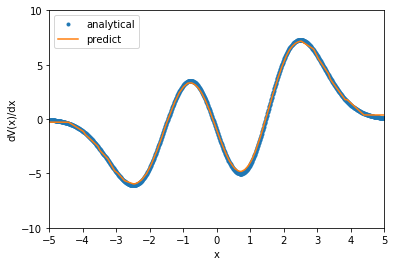

In [9]:
def dVdx_analytical(x):
    '''
    compute the analytical solution of potential surface gradient
    '''
    Ea = -10.0; x_a = -1.5; sigma_a = 2.0
    Eb = -12.0; x_b = 1.5 ; sigma_b = 2.0
    return -2.0*Ea*(x-x_a)/sigma_a*np.exp(-(x-x_a)**2 / sigma_a ) - 2.0*Eb*(x-x_b)/sigma_b*np.exp(-(x-x_b)**2/sigma_b)

delta = 0.5
x = np.linspace(-5,5,1000)

dVdx_predict = []
for xx in x :
    dVdx = ( model.predict(np.array([xx-delta*0.5, xx+delta*0.5])) * V_x_std ) + V_x_mean 
    dVdx_predict.append( (dVdx[1] - dVdx[0])/delta )
    
plt.plot(x, dVdx_analytical(x), ".", label='analytical')
plt.plot(x, dVdx_predict, label='predict')
plt.xlim(-5,5)
plt.ylim(-10,10)
plt.xticks(np.arange(-5.0, 5.01, 1.0))
plt.yticks(np.arange(-10.0, 10.01, 5.0))
plt.xlabel("x")
plt.ylabel("dV(x)/dx")
plt.legend()
plt.show()


## Brownian motion in a potential enregy surface
Now, let's place a Browian particle in the system. 
1. The thermal energy $k_BT$ is chosen to be the energy unit and the friction coefficient is chosen as $\gamma = 50$. 
2. The time evoluation of the particle is given by equation (2) with the time step size $dt = 0.1$. 
3. The force due to the presence of potential gradient acting on the particle is computed using equation (1) with the value of V(x) computed using the trained neural network.  

In [10]:
# Simulating Brownian motion in a potential enregy surface

# system parameters
kT = 1.0
gamma = 50.0
D = kT/gamma

# simulation time step and sampling rate (every unit time)
dt = 0.1
sampling_rate = int(1.0/dt)
n_step = 100000

# precalculate the factors used in simulation
delta = 0.5 
sqrt_2Ddt = np.sqrt(2.0*D*dt)
gamma_inv_dt = dt/gamma

# motor trajectory
x_trajectory = []   
V_x_trajectory = []

# random forces
np.random.seed(21)
random_force = np.random.randn(n_step)*sqrt_2Ddt

# initial position of the Brownian particle
x0 = np.array([-2.0]) 

# run simulation
for i, ran_force in enumerate(random_force):
    
    # compute local gradient using the prediction of the trained network at the current point
    dVdx = model.predict(np.array([x0-delta*0.5, x0+delta*0.5, x0])) * V_x_std + V_x_mean 
    Vx = dVdx[2]
    dVdx = (dVdx[1] - dVdx[0])/delta
    
    # store particle trajectory 
    if i%sampling_rate == 0 : 
        x_trajectory.append(x0)
        V_x_trajectory.append(Vx)
        
    # update particle poisiton with a white noise
    x0 = x0 - gamma_inv_dt*dVdx + ran_force

x_trajectory = np.array(x_trajectory)
V_x_trajectory = np.array(V_x_trajectory)

#### Plot the trajectory 

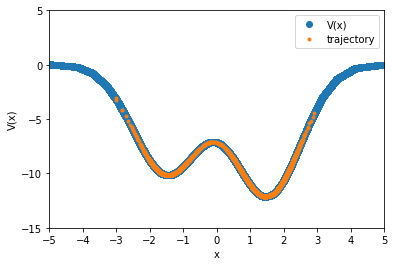

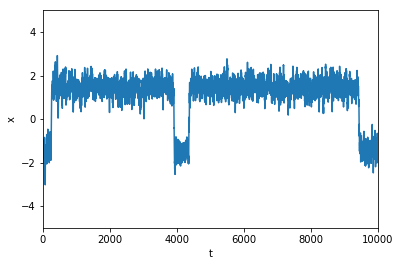

In [11]:
# plot trajectory on the potential energy surface
plt.plot(X_test, V_x_predict, "o", label="V(x)")
plt.plot(x_trajectory, V_x_trajectory, ".", label = "trajectory")
plt.xlim(-5,5)
plt.ylim(-15,2.5)
plt.xticks(np.arange(-5.0, 5.01, 1.0))
plt.yticks(np.arange(-15.0, 5.01, 5.0))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.legend()
plt.show()

# plot trajectory as a function of time
plt.plot(x_trajectory,"-")
plt.xlim(0,len(x_trajectory))
plt.ylim(-5, 5)
plt.xlabel("t")
plt.ylabel("x")
plt.show()

## Equilibrium distribution

To further test the validity of the potential energy surface represented by the neural network, we consider the distribution of an ensemble of 100 Brownian particles. At equilibrium, the ratio of the among of particles in well $a$ ($N_a$) and in well $b$ ($N_b$) is
\begin{align}
&\frac{N_a}{N_b} = e^{(E_a - E_b)/k_BT}.
&\mbox{Equation (5)}
\end{align}
With $E_a = -10$, $E_b = -12$ and $k_BT = 1$, the ratio $N_a/N_b \simeq 0.135$ meaning that there will be more particles locate in the well $b$ than in well $a$. It is because the energy barrier for a particle to move from $b$ to $a$ is higher than that from $a$ to $b$.


In [12]:
# Simulating an ensemble of Brownian particles in a potential enregy surface

kT = 1.0
gamma = 50.0
D = kT/gamma

delta = 0.5
dt = 0.1

gamma_inv_dt = dt/gamma
sqrt_2Ddt = np.sqrt(2.0*D*dt)

n_particle = 100
n_step = 100000
x0 = ( np.random.rand(n_particle) - 0.5 ) * 3.0 # initial position of the Brownian particle

np.random.seed(21)
random_force = np.random.randn(n_step, n_particle) * sqrt_2Ddt

x_trajectory = []   # motor trajectory
for i, ran_force in enumerate(random_force):
    
    # compute local gradient at the current point
    V_x_minus_delta = model.predict(x0-delta*0.5).reshape(n_particle) * V_x_std + V_x_mean  
    V_x_plus_delta = model.predict(x0+delta*0.5).reshape(n_particle) * V_x_std + V_x_mean 

    if i%10 == 0 : 
        x_trajectory.append(x0)
        
    x0 = x0 - gamma_inv_dt*(V_x_plus_delta - V_x_minus_delta) / delta + ran_force
    
x_trajectory = np.array(x_trajectory)

In [13]:
# Count the number particles near each bottom of each well

# location of the the bottom of wells a and b
x_a = -1.5
x_b = 1.5

# lable particle location 
location = ["a" if ((x < x_a+0.5) & (x >x_a-0.5)) else 
            "b" if ((x < x_b+0.5) & (x >x_b-0.5)) else 
            "other" 
            for x in x_trajectory.reshape(int(n_particle*n_step/10))]

from collections import Counter

dict_location = Counter(location)

print("N_a/N_b = exp(Ea-Eb/kBT):")
print("Using equation (5) one gets %f" %  0.135)
print("From simulation one gets %f" % (dict_location["a"]/dict_location["b"]) )


N_a/N_b = exp(Ea-Eb/kBT):
Using equation (5) one gets 0.135000
From simulation one gets 0.182812


### Summary
We have shown that a neural network is able to be used for the reconstruction of a potential surface in one dimension. For training, the input to the network is the coordinate (position) and the output is the corresponding potential energy. After training, we demonstrate that one is able to simulate the dynamics of a Brownian particle moving on a potential energy surface represented by a neural network. 

This method can be extended to problems with high dimensional energy surface, for example, protein folding problem. Proteins are formed by sequences of amino acid residues. In the folding funnel hypothesis, the free energy of a folded protein is assumed to be the global minimum of the free energy surface. Therefore, if one can find a way to construct a neural network for the free energy surface and the trained network can be used for the studies of protein dynamics.